In [5]:
# Mount Drive
from google.colab import drive
MOUNT_PATH = '/content/drive/'
drive.mount(MOUNT_PATH)

import sys
PROJECT_PATH = 'MyDrive/UCY/NLP/AirBnB_project'
EFFECTIVE_PROJECT_PATH = f'{MOUNT_PATH}{PROJECT_PATH}'
DATASET_PATH = f'{EFFECTIVE_PROJECT_PATH}/Dataset'

sys.path.append(EFFECTIVE_PROJECT_PATH)
sys.path.append(DATASET_PATH)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [6]:
!pip install transformers
!pip install sentence-transformers
%clear

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
%load_ext tensorboard

In [8]:
from dataloader import Dataloader
data = Dataloader(
    listing_path = f'{DATASET_PATH}/listings',
    comments_path = f'{DATASET_PATH}/comments',
)
# Aproach 1 only listing data 
# Aproach 2 only reviews (Advanced analysis)
# Aproach 3 comninede

# Develop clustering o present vocabulary to express the different dimension (clean, communication checkin, value)
# Use bucket of 0-1 1-2 2-3 3-4 4-5
# 1 model for each dimension 

# Test more cities

In [9]:
# more than 1 listing
listings = data.getListings()
listings = listings.sample(1000)
listings.sample(3)['amenities']

5688    ["Smoke alarm", "TV with Amazon Prime Video", ...
24      ["Smoke alarm", "Fire extinguisher", "Luggage ...
1260    ["Smoke alarm", "Fast wifi \u2013 383 Mbps", "...
Name: amenities, dtype: object

In [10]:
rating_cols = [col for col in listings.columns if "scores" in col]
listings[rating_cols]

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
6443,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3877,5.00,5.00,5.00,5.00,5.00,5.00,5.00
3348,4.69,4.94,4.81,5.00,4.94,4.81,4.56
585,4.80,4.80,5.00,4.40,4.80,5.00,4.60
5146,5.00,5.00,5.00,5.00,5.00,5.00,5.00
...,...,...,...,...,...,...,...
3006,4.91,4.95,4.95,4.95,4.86,4.86,4.59
1062,4.53,4.68,4.63,4.63,4.47,4.79,4.32
1431,4.17,4.39,4.57,4.23,4.70,4.64,4.32
3140,5.00,4.88,5.00,5.00,5.00,4.88,4.75


# Sentence Transformes Aproach

In [11]:
%%time
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
import json

# used a fast model
model = SentenceTransformer('all-MiniLM-L12-v2')
%clear

scores = listings[rating_cols]
encodings = {}
strings = {}
for idx, listing in tqdm(listings.iterrows()):
  amenities = json.loads(listing['amenities'])
  a_string = " ".join(amenities)
  encoding = model.encode(a_string)
  encodings[idx] = encoding

# Extract the amenities from the data frame and explode them in a list for each element

%clear

1000it [02:32,  6.55it/s]


CPU times: user 2min 6s, sys: 1.31 s, total: 2min 7s
Wall time: 2min 37s


In [12]:
# Visualization
import plotly.graph_objs as go
def visualize_embedding_3D(components, ratings, title):
  trace = go.Scatter3d(
      x=components[:,0],
      y=components[:,1],
      z=components[:,2],
      mode='markers',
      marker=dict(
          color=ratings,
          size=5,
          colorscale='Viridis',
          opacity=0.8,
          colorbar=dict(title=title)
      )
  )

  # create the layout for the plot
  layout = go.Layout(
      margin=dict(
          l=0,
          r=0,
          b=0,
          t=0
      ),
      scene=dict(
          xaxis_title='X',
          yaxis_title='Y',
          zaxis_title='Z'
      ),
      title=dict(text=title)
  )

  # create the figure and plot it
  fig = go.Figure(data=[trace], layout=layout)
  fig.show()

def visualize_embedding_2D(components, ratings, title):
  trace = go.Scatter(
      x=components[:,0],
      y=components[:,1],
      mode='markers',
      marker=dict(
          color=ratings,
          size=5,
          colorscale='Viridis',
          opacity=0.8,
          colorbar=dict(title=title)
      )
  )

  # create the layout for the plot
  layout = go.Layout(
      margin=dict(
          l=0,
          r=0,
          b=0,
          t=0
      ),
      scene=dict(
          xaxis_title='X',
          yaxis_title='Y',
      ),
      title=dict(text=title)
  )

  # create the figure and plot it
  fig = go.Figure(data=[trace], layout=layout)
  fig.show()

In [13]:
#embedding visualization, to se if we can detect something
import numpy as np
from sklearn.manifold import TSNE


tsne = TSNE(n_components=2, perplexity=30.0, random_state=0)
vectors = np.vstack(encodings.values())
reduced_vectors = tsne.fit_transform(vectors)
print(reduced_vectors.shape)

for score in rating_cols:
  visualize_embedding_2D(reduced_vectors, listings[score], score)

<ipython-input-13-e4f05c102164>:7: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = np.vstack(encodings.values())


(1000, 2)


# Clustering

We want to try to extract a clustering approach to se if we can use the appartence to clusters as the effective feature to give to the model

In [14]:
# Pre-Processing Functions
import nltk
import itertools
import string
import re
from collections import Counter
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
from nltk.stem import PorterStemmer
import pickle
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import json

nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

from tqdm import tqdm

# The amenities are a list of smal descriptions, as such first we have to tokenize them then i will generate a sngle array with all the dscrioom on the documents
def tokenize_amenities(listings):
  tokens_list = []
  for idx, listing in tqdm(listings.iterrows()):
      amenities_list = json.loads(listing['amenities'])
      amenities = [ word_tokenize(uncontract(a)) for a in  amenities_list]
      tokens_list.append(amenities)

  return tokens_list


# Uncontract contracted forms
def uncontract(text):    
  text = re.sub(r"(\b)([Aa]re|[Cc]ould|[Dd]id|[Dd]oes|[Dd]o|[Hh]ad|[Hh]as|[Hh]ave|[Ii]s|[Mm]ight|[Mm]ust|[Ss]hould|[Ww]ere|[Ww]ould)n't", r"\1\2 not", text)
  text = re.sub(r"(\b)([Hh]e|[Ii]|[Ss]he|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'ll", r"\1\2 will", text)
  text = re.sub(r"(\b)([Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Yy]ou)'re", r"\1\2 are", text)
  text = re.sub(r"(\b)([Ii]|[Ss]hould|[Tt]hey|[Ww]e|[Ww]hat|[Ww]ho|[Ww]ould|[Yy]ou)'ve", r"\1\2 have", text)
  
  text = re.sub(r"(\b)([Cc]a)n't", r"\1\2n not", text)
  text = re.sub(r"(\b)([Ii])'m", r"\1\2 am", text)
  text = re.sub(r"(\b)([Ll]et)'s", r"\1\2 us", text)
  text = re.sub(r"(\b)([Tt]here)'s", r"\1\2 is", text)
  text = re.sub(r"(\b)([Ww])on't", r"\1\2ill not", text)
  text = re.sub(r"(\b)([Ss])han't", r"\1\2hall not", text)
  text = re.sub(r"(\b)([Yy])(?:'all|a'll)", r"\1\2ou all", text)
  text = text.replace('"', " ") # Removes " Characters
  
  return text

# Given an original token list return an valutation function to compare against it
def gen_dimensionality_info(orignial_tokens, name):
  orignial_tokens = list(itertools.chain.from_iterable(orignial_tokens))
  def dimensionality_info(token_list):
    token_list = list(itertools.chain.from_iterable(list(itertools.chain.from_iterable(token_list))))
    print(f'Number of {name} Tokens:               ', len(token_list), '/', len(orignial_tokens))
    print(f'Unique {name} Tokens:                  ', len(set(token_list)), '/', len(set(orignial_tokens)))
    print()
    print('Reduction pecentage:            ', 1-(len(token_list) / len(orignial_tokens)))
    print('Reduction pecentage Unique:     ', 1-(len(set(token_list)) / len(set(orignial_tokens))))
    print()
    print('Most Common of current filter:')
    for t, f in Counter(token_list).most_common(10): print('{0:25} {1}'.format(t, f))
    print('################################################################')
    print()
  
  return dimensionality_info

# Remove all the punctuation only tokens
def remove_puctuation_only_token(tokens):
  return list(filter(lambda t: not all(c in string.punctuation for c in t), tokens))

# Remove Numbers
def remove_numbers(tokens):
  return list(filter(lambda t: not t.isnumeric() , tokens))

# remove the stop words from the tokens
def remove_stop_words(tokens):
  stop_word_regex = '|'.join(['^{}$'.format(s) for s in stopwords.words('english')])
  stop_word_regex = re.compile(stop_word_regex)
  return list(filter(lambda t: not stop_word_regex.match(t), tokens))

nltk.download('wordnet')
nltk.download('omw-1.4')
def lemmatize(tokens):
  lemmatizer = WordNetLemmatizer()
  return [lemmatizer.lemmatize(t) for t in tokens]

# Lowercase the text
def lowercase(tokens):
  return [t.lower() for t in tokens]

# Remove the the tokens made only by ’
def remove_special_tokens(tokens):
  return [t for t in tokens if  '’' != t]

# Sequentially Apply a list of token processing funtions
def apply_process_list(tokens, processing):
  for p in processing:
    tokens = [p(token) for token in tokens]
  return tokens

PRE_PROCESSING = [lowercase, remove_puctuation_only_token, remove_numbers, remove_stop_words, remove_special_tokens, lemmatize]
def pre_process(docs, remove_less_than=3):
  docs_tokens = tokenize_amenities(docs)
  docs_tokens = [apply_process_list(doc, PRE_PROCESSING) for doc in docs_tokens]
  return docs_tokens


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
# Generate the raw token info to make the info function
tokenize_amenities_raw = list(itertools.chain.from_iterable(tokenize_amenities(listings)))
print_dim_info = gen_dimensionality_info(tokenize_amenities_raw, name="Amenities")

1000it [00:03, 294.45it/s]


In [16]:
test = list(tokenize_amenities(listings))
test[0]

1000it [00:03, 267.14it/s]


[['Smoke', 'alarm'],
 ['Kitchen'],
 ['Wifi'],
 ['Fire', 'extinguisher'],
 ['Long', 'term', 'stays', 'allowed'],
 ['Washer'],
 ['Security', 'cameras', 'on', 'property'],
 ['TV', 'with', 'Netflix'],
 ['Shampoo'],
 ['Essentials'],
 ['Dedicated', 'workspace'],
 ['First', 'aid', 'kit'],
 ['Air', 'conditioning'],
 ['Carbon', 'monoxide', 'alarm']]

In [17]:
amenities_tokens = pre_process(listings)
amenities_tokens[0]

1000it [00:05, 186.18it/s]


[['smoke', 'alarm'],
 ['kitchen'],
 ['wifi'],
 ['fire', 'extinguisher'],
 ['long', 'term', 'stay', 'allowed'],
 ['washer'],
 ['security', 'camera', 'property'],
 ['tv', 'netflix'],
 ['shampoo'],
 ['essential'],
 ['dedicated', 'workspace'],
 ['first', 'aid', 'kit'],
 ['air', 'conditioning'],
 ['carbon', 'monoxide', 'alarm']]

In [18]:
# As is expected since thei are more or less few specific words
print_dim_info(amenities_tokens)

Number of Amenities Tokens:                57823 / 63858
Unique Amenities Tokens:                   438 / 643

Reduction pecentage:             0.09450656143317981
Reduction pecentage Unique:      0.3188180404354588

Most Common of current filter:
alarm                     1437
dryer                     1199
allowed                   1171
hot                       1076
water                     1045
wifi                      1026
coffee                    1001
heating                   912
essential                 911
private                   893
################################################################



In [19]:
# # Remove tokens that appear less than x
# def remove_token_by_count(docs, lesser_eq_than):
#   tokens_linear = itertools.chain.from_iterable(list(itertools.chain.from_iterable(docs)))
#   print(list(tokens_linear))
#   token_freq = dict(Counter(tokens_linear))
#   tokens_appeared_leq = set([t for t, v in token_freq.items() if v <= lesser_eq_than])
#   filtered = []
#   for doc in docs:
#     filtered = [list(filter(lambda t: t not in tokens_appeared_leq, a)) for a in doc]
#   return filtered

# amenities_tokens_no_rares = remove_token_by_count(amenities_tokens, 1)

We will now try to see if cluster with similar amenities are present, to do so we flatt the structure (Listing-> amenities embeddings list ) to ( amenities embeddings list) and work on those.

In [20]:
vectorize_model = None
def unqies_amenities(amenities):
  res_list = []
  test = []

  for item in amenities: 
      if "".join(item) not in test:
          res_list.append(item)
          test.append("".join(item))

  return  res_list

In [21]:
import gensim.downloader
# Apply of w2v to extract vectorization of amenities
def vectorize(docs, model_name='glove-wiki-gigaword', size=300, w2v_model=None):
  if w2v_model == None: w2v_model =  gensim.downloader.load(f'{model_name}-{size}')
  documents_vector = []
  for d in docs:
    vectorized_amenity_tokens = [w2v_model[t] for t in d if t in w2v_model]
    documents_vector.append(np.zeros(shape=(size)) if len(vectorized_amenity_tokens) == 0 else np.mean(vectorized_amenity_tokens, axis=0))

 
  return documents_vector, w2v_model

amenities_flat = list(itertools.chain.from_iterable(amenities_tokens))
print("With copies: ", len(amenities_flat))
amenities_flat = unqies_amenities(amenities_flat)
print("Uniques: ", len(amenities_flat))
vectorized_amenities, vectorize_model = vectorize(amenities_flat, w2v_model=vectorize_model)

With copies:  29345
Uniques:  561


In [22]:
%%time
# Cluestering 
from scipy.cluster.hierarchy import ward, fcluster, linkage
Z = linkage(vectorized_amenities,'average', metric='cosine')

CPU times: user 44.5 ms, sys: 995 µs, total: 45.5 ms
Wall time: 47.3 ms


In [23]:
clusters = fcluster(Z, 0.50, criterion='distance')
print('Number of Clusters:', len(set(clusters)), '/', len(vectorized_amenities))

Number of Clusters: 97 / 561


In [36]:
%%time
###############################
# Precompute embeddings names #
###############################
amenity_name = [' '.join(a) for a in amenities_flat]
amenities_names = [vectorize_model.most_similar(positive=[vectorized_amenity], topn=1)[0] for vectorized_amenity in vectorized_amenities]
amenities_strings = []
for idx, listing in tqdm(listings.iterrows()):
  amenities = json.loads(listing['amenities'])
  a_string = " ".join(amenities)
  amenities_strings.append(a_string)


0it [00:00, ?it/s]


AttributeError: ignored

In [53]:
###############################
# Define a cluster dictionary #
###############################

cluster_dict = {}
cluster_embeddings = {}
len(vectorized_amenities)
len(strings)
for i, c in enumerate(clusters):
  
  ##############################
  # Initialize a cluster array #
  ##############################

  if c not in cluster_dict: cluster_dict[c] = []
  if c not in cluster_embeddings: cluster_embeddings[c] = []

  #########################################
  # Populate the cluster with the texts,  #
  # their processed form, and their label #
  # i.e. gun-related or mideast-related.  #
  #########################################
  similar_amenity, confidence = amenities_names[i]
  cluster_dict[c] += [{'text': amenities_strings[i], 'encoded': similar_amenity, 'confidence': confidence, 'encoding': vectorized_amenities[i]}]
  cluster_embeddings[c].append(vectorized_amenities[i])

# Extract cluster names
for c, e in cluster_embeddings.items():
  embedding = np.vstack(e).mean(axis=0)
  cluster_name, _ = vectorize_model.most_similar(positive=[embedding], topn=1)[0]
  cluster_embeddings[c] = {
      "name": cluster_name,
      "embedding": embedding
  }

In [57]:
from collections import Counter

biggest_clusters = sorted(
    cluster_dict.keys(),
    key     = lambda c: len(cluster_dict[c]),
    reverse = True
)[:9]

for c in biggest_clusters:
  cluster_name = cluster_embeddings[c]['name']
  print(f'Cluster {c} - {cluster_name}')
  print()
  
  for t in Counter([t['encoded'] for t in cluster_dict[c]]).most_common(): 
    print('- {0:35} {1}'.format(t[0], t[1]))

  print()
  print('- {0:35} {1}'.format('Total Entries:', len(cluster_dict[c])))
  print()

Cluster 59 - cable

- cable                               42
- netflix                             18
- tv                                  14
- video                               14
- hdtv                                10
- hbo                                 3
- dvd                                 1

- Total Entries:                      102

Cluster 48 - stove

- stainless                           21
- stove                               7
- induction                           6
- gas                                 3
- electric                            2
- aeg                                 2
- oven                                2
- steel                               1

- Total Entries:                      44

Cluster 58 - sound

- sound                               16
- bluetooth                           10
- system                              8
- kardon                              2
- google                              1
- connect                             1

- To

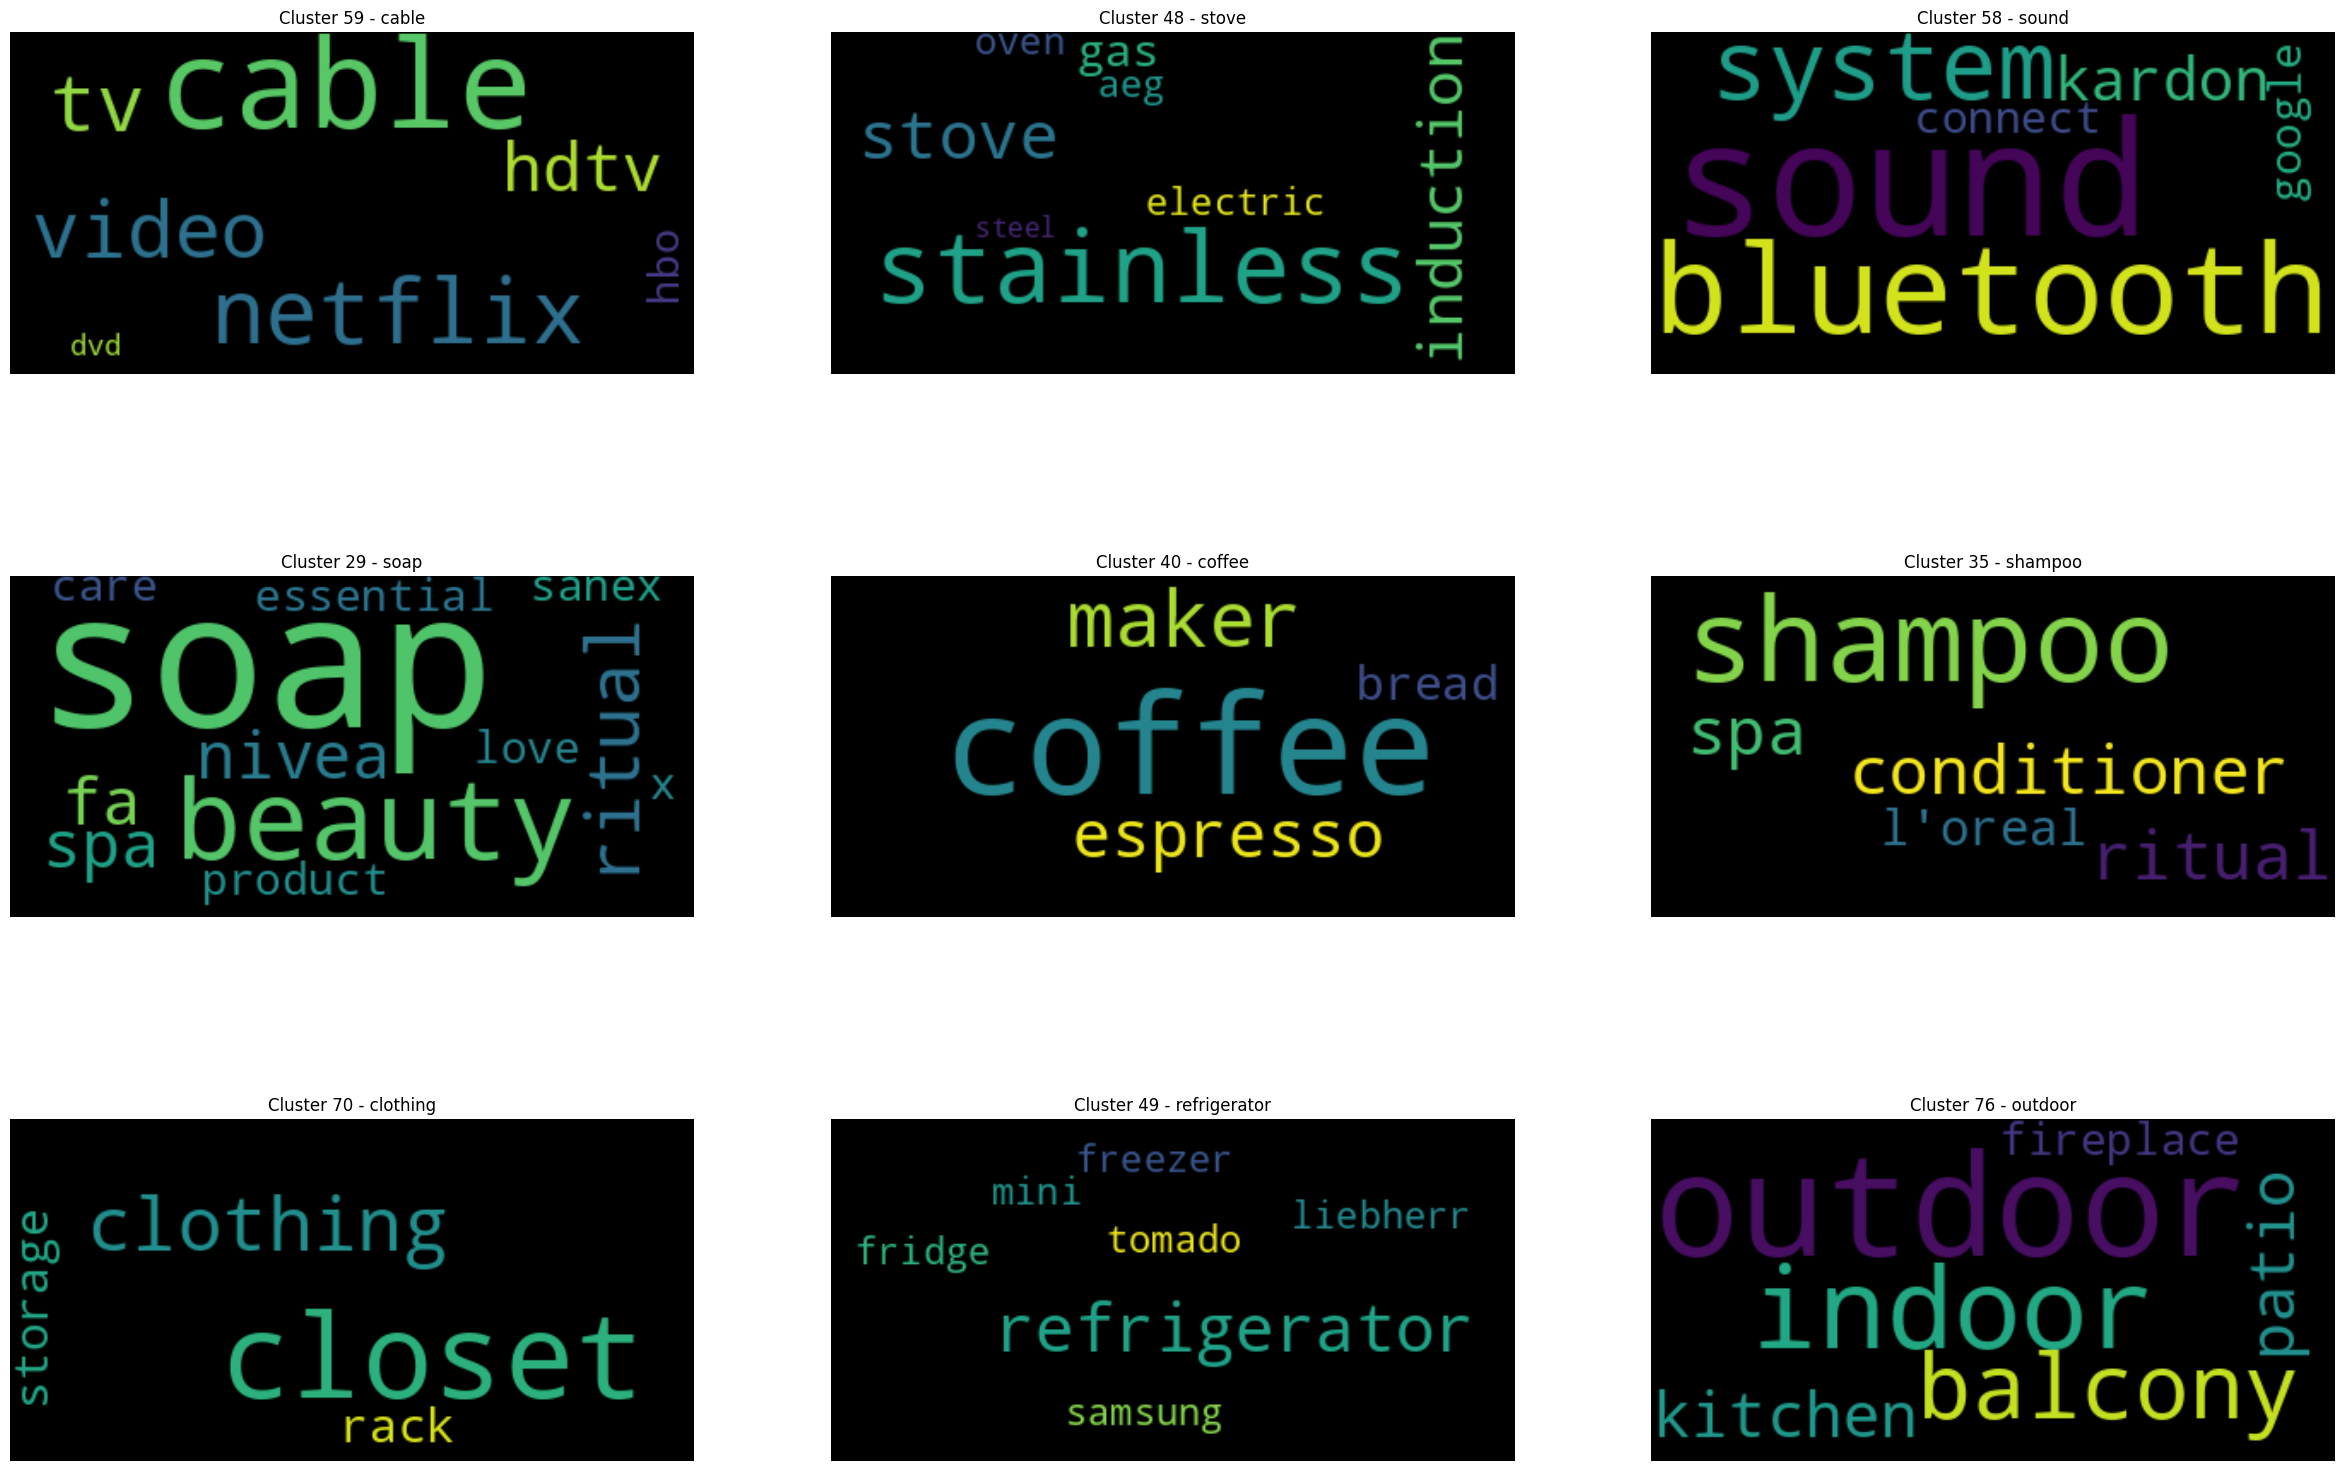

In [86]:
import matplotlib.pyplot as plt, itertools
from wordcloud import WordCloud
from collections import Counter

fig, axes = plt.subplots(3, 3, figsize=(30, 20))

for i, c in enumerate(biggest_clusters[:9]):
  cluster_name = cluster_embeddings[c]['name'] 
  wordcloud_c = WordCloud().generate_from_frequencies(
      Counter(list([
    t['encoded'] for t in cluster_dict[c]
  ])))

  axes[int(i/3)][i%3].imshow(wordcloud_c, interpolation='bilinear')
  axes[int(i/3)][i%3].axis("off")
  axes[int(i/3)][i%3].set_title(f'Cluster {c} - {cluster_name}')

plt.show()